In [1]:
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
from __future__ import division, print_function, absolute_import
import numpy as np
import tensorflow as tf
import h5py
import glob
import sys, os
from NetworkSwitch import *
from sklearn.preprocessing import scale
from skimage.util import view_as_windows as vaw
from numpy import random as npr
from scipy.misc import imresize, bytescale
import time

In [2]:
# define useful variables
os.chdir('/home/TF_Rover/RoverData/Right2')
fnames = glob.glob('*.h5') # datasets to train on
fnames = fnames[::2]
iters = 200 # number of training iterations
batch_sz = 200  # training batch size
k = 1000
patch_sz = 15
val_name = 'Run_218seconds_Michael_Sheri.h5' # Dataset to use for validation
imsz = 100

In [3]:
def create_framestack(x, y, f_int, f_int2):
    X_ = []
    Y_ = []
    for ex_num in range(x.shape[0]-1, f_int2, -1):
        X2 = x[ex_num-f_int, :, :, :]
        X3 = x[ex_num-f_int2, :, :, :]
        X_.append(np.concatenate((x[ex_num, :, :, :], X2, X3), 2))
        Y_.append(y[ex_num, :])
    return np.asarray(X_), np.asarray(Y_)

In [4]:
def get_patches(X, ps):
    X = vaw(X, (1, ps, ps))
    subsample = np.int32(ps/2+1)
    X = X[::20, ::subsample, ::subsample, ...]
    num_patches = X.shape[0]*X.shape[1]*X.shape[2]*X.shape[3]
    return np.transpose(X.reshape([num_patches, -1]))

In [5]:
def plot2(a, e):
    # plot a histogram of the sparse coefficients 
    # and the error rate over time
    fig = plt.figure()
    a1 = fig.add_subplot(121)
    a1.plot(e[1:, 0])
    a1.set_ylabel('l2 error')
    a1.set_xlabel('Iteration')
    a2 = fig.add_subplot(122)
    a2.hist(a)
    a2.set_ylabel('Number of coefficients')
    a2.set_xlabel('Activation')
    plt.show()
    return

In [6]:
def mat2ten(X):
    zs=[X.shape[1], int(np.sqrt(X.shape[0])), int(np.sqrt(X.shape[0]))]
    Z=np.zeros(zs)
    
    for i in range(X.shape[1]):
        Z[i, ...]=np.reshape(X[:,i],[zs[1],zs[2]])
        
    return Z

In [7]:
def montage(X):    
    count, m, n = np.shape(X)    
    mm = int(np.ceil(np.sqrt(count)))
    nn = mm
    M = np.zeros((mm * m, nn * n))

    image_id = 0
    for j in range(mm):
        for k in range(nn):
            if image_id >= count: 
                break
            sliceM, sliceN = j * m, k * n
            M[sliceN:sliceN + n, sliceM:sliceM + m] = bytescale(X[image_id, ...])
            image_id += 1
    return M

In [8]:
def plot(x):
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap='gray')
    ax.axis('off')
    fig.set_size_inches(18, 18)
    plt.show()

In [9]:
def file_get(filename):
    f = h5py.File(filename, 'r')
    X = np.asarray(f['X'])
    f.flush()
    f.close()
    return np.mean(X, 3)

In [10]:
def resize_images(X, newsize):
    x = []
    
    for i in range(X.shape[0]):
        x.append(imresize(X[i, ...], [newsize, newsize]))
        
    return np.asarray(x)

In [11]:
def compile_ims(num_ims):
    x = np.zeros([patch_sz**2, num_ims * len(fnames)])
    
    for i in range(len(fnames)):
        print(i)
        X = file_get(fnames[i])
        X = X[npr.randint(0, X.shape[0], 150), ...]
        X = resize_images(X, imsz)
        X = get_patches(X, patch_sz)
        x[..., i*num_ims:i*num_ims+num_ims] = X[:, :num_ims]
        
    return x

(225, 13200)


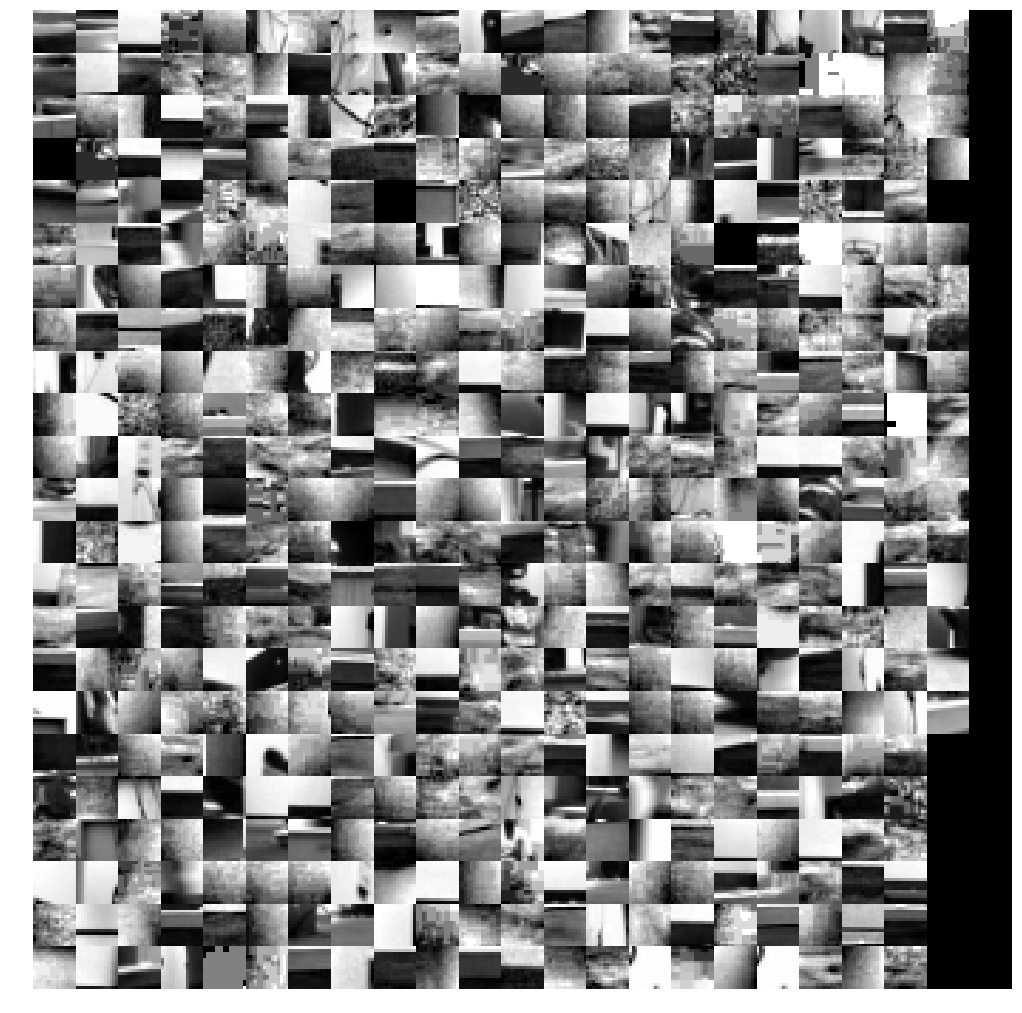

23.5439450741


In [12]:
with tf.Session() as sess:

    try:
        f = h5py.File('rover_patches.h5', 'r')
        X = np.asarray(f['X'])
        f.close()
    except IOError:
        X = compile_ims(600)
        f = h5py.File('rover_patches.h5', 'a')
        f.create_dataset('X', data=X)
        f.close()
        
    print(X.shape)
        
    # plot some of the patches
    plot(montage(mat2ten(X[:, npr.randint(0, X.shape[1], 500)])))
    #print(np.unique(X))

    # name to save each dictionary and coefficients as 
    save_name = str(patch_sz)

    start = time.time()
    
    # send data to network and get back dictionary and coefficients
    D, A, E = X3(X, iters, batch_sz, num_dict_features=k, white=True)
    
    print(time.time() - start)

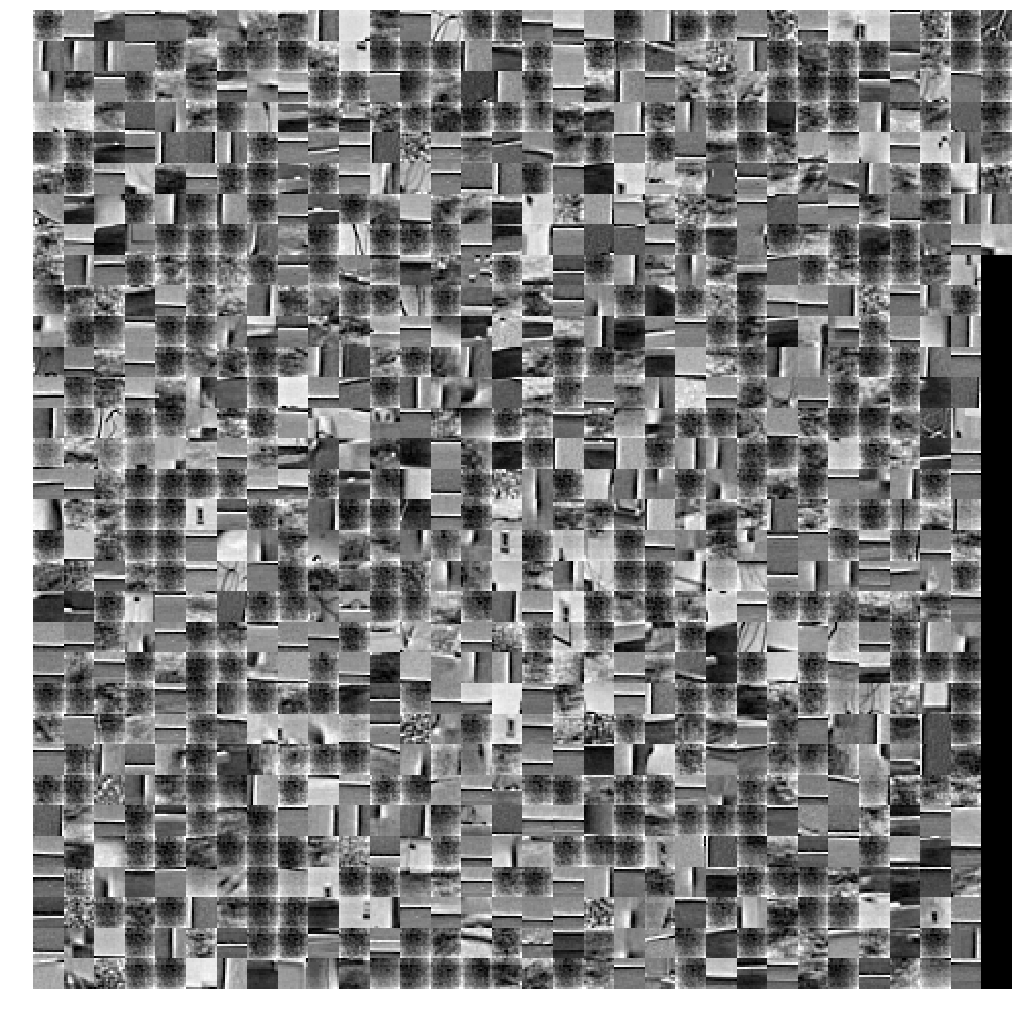

In [13]:
# visualize the learned dictionary
plot(montage(mat2ten(D)))

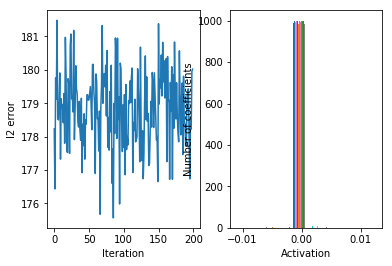

In [14]:
plot2(A, E) # plot coefficients and error